<h1 style="text-align: center;"><img src="images/uw.png" width="90" height="90" style="float:left" alt="ServiceX"><img src="images/logo_servicex.png" width="90" height="90" style="float:right" alt="IRIS-HEP">IRIS-HEP ServiceX Tutorial test</h1>

<h4 style="text-align: center;">Artur Cordeiro Oudot Choi (University of Washington)</h4><h4 style="text-align: center;">IRIS-HEP Analysis Software Training Event (July 2025)</h4>

---

## 1 – Introduction

This notebook starts with a presentation of ServiceX and its benefits compared to some current ATLAS software resources for some frequent tasks. The second part of the notebook will give showcase ServiceX features and examples on how to use it. 
At the end of the notebook, you are encouraged to try out servicex and follow a recommended exercise. 

#### **The Worldwide LHC Computing Grid**

  The WLCG, Grid for short, provides computing resources for storage and data-analysis for LHC experiments. It is spread across 170 sites in 42 countries, utilizing CERN and national institutes' infrastructure. The grid stores ATLAS's collected experimental data and centrally produced MC simulations but also user-produced datasets (custom derivations, skimmed Ntuples, private simulations).

  The Grid is a crucial tool for ATLAS to:

  - deal with the total file-size of datsets that can easily saturate any user storage
  - allow frequent dataset access worldwide
  - Provide computing power in a batch system for heavy tasks: computing systematic errors, doing simulations, running reconstruction algorithms

However, using the Grid requires many different and sometimes complex ATLAS tools. This presents barriers for simple dataset exploration task or R&D on targeted features that do not require large computing power. 

#### **Managing Datasets for analyses**

  When working with the Grid within an analysis group as privately there are many points to include in your workflow.
  
  The current DS management workflow can include:
  - Official requests for large storage spaces for each analysis team (`eos`, `groupsdisk`)
  -  Institute-provided machines $\star$
      - storage + access to ATLAS tools  
  - Sending ntuplizer jobs on the grid to skim DS $\star$
      -  event pre-selection, triggers, working points, High-level variable construction, dropping low-level information
      -  Often requires Athena or AnalysisBase
          - Different releases require different setups, containers   
      -  custom reconstructions ...
      -  Done using `panda`
          -  Difficult debugging
          -  Difficult access to logs
          -  different protocols for different types of tasks
  -  Downloading full or partial DS, skimmed Ntuples with `rucio` $\star$
  - Managing all productions
      - Deleting older files
      - requesting DS persistence exceptions
      - requesting larger group storage

<break>
    
    
### **What is ServiceX?**


ServiceX is a modern tool that manages to replace parts of this workflow ($\star$), aiming to simplify frequent light R&D tasks that usualy require the Grid.


<h1 style="text-align: center;"><img src="images/what-is-sx.jpeg" alt="sx-benefits" width="900" height="100"></h1>


  ServiceX is a data transformation and delivery system that simplifies the data access workflow for physics analyses. The system is deployed on a Kubernetes cluster, allowing quick and scalable operations with parallel transformers and access to multiple services.
  It is part of IRIS-HEP DOMA (Data Organization, Management And Access) and aims to interface datasets and user-level analysis code for the HL-LHC in a Python environment.
  
#### **ServiceX main use cases**

  
  - Pull only the columns or features needed without having to download full files
  -  Apply cuts to data, delivering only a portion of events to:
      - Quickly prototype cutflows
      - Target studies on unusual events, calibration errors...
      - No need to sumbmit `panda` jobs to run on lxplus on downloaded samples
  -  Integrate analyses in a Python-based framework (`coffea`, `RDataFrame`, `awkward`)
  -  Work with multiple data formats on the same system (xAOD, DAOD, Ntuple Trees, RNTP, parquet)
  -  Access to multiple releases of ATLAS AnalysisBase
  -  Access different remote storage (`rucio`, `eos`, `CernOpenData`)
  -  Setup a lightweight python package locally instead of ATLAS software environment on remote machines.
  -  Write data transformations in a few lines of code with declarative syntax 

<break>  
    
#### **How does it work?**
- <u>Query-based data transformation and delivery<u>

  Users send HTTPS requests to the ServiceX Web API using the [client library](https://github.com/ssl-hep/ServiceX_frontend). Each request contains an input sample ID/path and all data transformations to be applied and dumped to the result file.

 - <u>Remote data access<u>

   After receiving a request, the Web API sends the requested sample name to a Dataset Finder service which finds a way to get it via the Grid, XRootD or CernOpenPortal. ServiceX can also be deployed on a grid site which would maximize bandwidth to get samples faster. 

 - <u>Code Generation<u>


   Executable code is generated from the query specifications sent to the Web API. ServiceX builds this Python or C++ code by leveraging abstract syntax trees and functional programming. This means users can express complex data processing in a few lines. Multiple query types are available with different syntax/code translation.

 - <u>Transformers and science images<u>

   To execute the generated code, the kubernetes cluster deploys transformer pods. Depending on the request, these pods require different environments. Each has its science image used to build containers, and they can include: python environements with awkward, uproot, RDataFrame and Root or Atlas software like AnalysisBase or TopCPToolkit...  The number of transformers deployed for one request scales with the number of files to be acessed in the requested dataset. By parallelizing the work on multiple files and merging the outputs, servicex delivers the results fast. 

 - <u>Object store<u>

   Transformed outputs are written to an S3-compatible store; users download just URLs or files as they become available.

<h1 style="text-align: center;"><img src="images/ServiceXDiagram2.png" alt="sx-benefits" width="1000" height="100"></h1>


<break>
 
#### **Minimal setup**

One great advantage of ServiceX is it's minimal setup. Most of the work happens in the backend thus leaving the front-end (user-facing) side very light. 

- ServiceX Front-end: A minimal Python library (client API), for defining queries and sending HTTPS queries to the web api
- ServiceX Back-end: The kubernetes system containing all microservices in static pods and transformer pods that interpret the queries, execute the data transformation, and store it to an S3 store. This is deployed at an analysis facility. 

  As a user you only interact with the client API (python script or with command lines) but you need to get token that grants access to the back-end server. 

This simple setup means that you can run ServiceX from anywhere: laptops, office machine, jupyter hub... 

For any information on the client API please check the [documentation](https://servicex-frontend.readthedocs.io)


The rest of this notebook is a hands-on tutorial

## 2 – Installation

### 2a - Client package


The [servicex](https://github.com/ssl-hep/ServiceX_frontend/tree/master) Pypi package is the only API you need to send queries and retrieve results. 
Installation bellow.

In [1]:
!pip install servicex

### 2b - Utilities package


In parallel, a [serivex_analysis_utils](https://github.com/ssl-hep/ServiceX_analysis_utils/tree/main) library is also in development to put together Servicex usability helpers and specific tools that use it.

In [2]:
!pip install servicex-analysis-utils

### 2c - Access to endpoint

For ATLAS the back-end instance you will use is [af.uchicago](https://servicex.af.uchicago.edu/)

You need to login using your ATLAS credentials (Cern SSO), got to your profile, and create/download the token `servicex.yaml`. <br>
Be sure to put this config file in your running path.

 <h1 style="text-align: center;"><img src="images/token.jpeg" alt="token" width="600" height="50"></h1>



In [3]:
import os
assert os.path.exists('servicex.yaml'), 'servicex.yaml not found in working directory'

## 3 – Building Your First ServiceX Request

There are multiple transformer types that ServiceX's backend can deploy. Each one requires a different type of query that is constructed using different syntaxes. <be>
Bellow you can find a table of currently supported transformations, their file formats (input and output), and the query type you need to use with ServiceX to send a request.

 <h1 style="text-align: center;"><img src="images/available-transforms.jpeg" alt="trans-types" width="600" height="50"></h1>


We will start by building one intuitive query for the `python` transformation. For this, you write down the actual function that is executed by the transformers. <br> 
The transformation request will consist on applying selection cuts on truth variables and reco objects, then it will dump the truth decay vertex of a BSM particle (axion-like-particle) and the EM fraction of reco jets.

In [4]:
#Import needed functions 
from servicex import deliver, query, dataset
from servicex_analysis_utils import to_awk

### 3.1 Runing a python function in the backend
ServiceX provides a trasnformer type that distributes a user-written python function. 

#### a - Building the query event selection
The python environment has access to all standard python libraries plus `uproot` and `awkward`. The user imports must be done within the function.

In [5]:
#The user function

def run_query(input_filenames):
    import uproot
    import awkward as ak
    """
    input_filenames : 
        The dataset specified in the query will be loaded here

    Returns
    -------
    ak.Array with fields truth_alp_decayVtxX, truth_alp_decayVtxY, jet_pt_NOSYS
    for events passing the selection cuts. The array will be saved in a file and sent to ServiceX's object store
    """
    # 1) Load the branches into a single awkward array with uproot
    treename="reco"
    branches = [
        "truth_alp_decayVtxX",
        "truth_alp_decayVtxY",
        "truth_alp_pt",
        "truth_alp_eta",
        "jet_EMFrac_NOSYS", 
        "jet_pt_NOSYS",
    ]
    
    with uproot.open(input_filenames) as f:
        tree = f[treename]
        arr = tree.arrays(branches, library="ak")

    # 2) Build the mask (cuts you want to apply)
    mask = ak.ravel(
        (abs(arr["truth_alp_eta"]) < 0.8) &
        (arr["truth_alp_pt"] > 20) &
        (ak.num(arr["jet_EMFrac_NOSYS"]) < 2)
    )

    # 3) Apply the mask and zip only the three output fields you need
    out = ak.zip({
        "truth_alp_decayVtxX": arr["truth_alp_decayVtxX"][mask],
        "truth_alp_decayVtxY": arr["truth_alp_decayVtxY"][mask],
        "jet_EMFrac_NOSYS":       arr["jet_EMFrac_NOSYS"][mask]
    }, depth_limit=1)

    return out

In [6]:
#build the servicex query object
python_query=query.PythonFunction().with_uproot_function(run_query)

#### b - Selecting the dataset

In [7]:
#NTuple stored in a group disk at LPC (France)
my_DS="user.acordeir:michigan-tutorial.displaced-signal.root" 
#Use the rucio dataset-types for the DSFinder 
request_DS=dataset.Rucio(my_DS)

#### c - Build the ServiceX request spec

In [8]:
# Define a simple query
spec = {
    'Sample': [{
        'Name': 'My_first_transform',
        'Dataset': request_DS,
        'Query': python_query
    }]
}

#### d - Send the request to the Web API

In [9]:
# Deliver the request
transformed_results = deliver(spec)

Output()

**Monitor transforms** <br>
By accessing the ServiceX [dashboard](https://servicex.af.uchicago.edu/dashboard) you should see your first request `'My_first_transform'` . <be>
From this page you can get specific details about your request, such as IDs to help navigate logs (later in the tutorial). You can also cancel transformations from here if you realise a job should be killed. It is good practice to avoid taking resources unecessarly, and cancelling the deliver function will not stop a request that was sent to the backend.

 <h1 style="text-align: center;"><img src="images/monitoring.png" alt="monitoring" width="800" height="80"></h1>


By default, ServiceX results from `deliver()` are downloaded from the object store into the user's cache `tmp/servicex_$user/`

In [10]:
# deliver returns a dict with a path to the result
print(transformed_results)

{'My_first_transform': ['/private/var/folders/rl/c_v3j6t97j51xfs8rjlh0sfx2djbcf/T/servicex_acordeir/e6e6b317-a910-40bb-93bc-f1298597abfd/root___c112.af.uchicago.edu_1094__root___eosatlas.cern.ch_1094__eos_atlas_atlasscratchdisk_rucio_user_acordeir_2c_e6_0p4GeV_alp_med_prod2.root']}


### 3.2 - Quick analysis example 
 ServiceX data delivery is particularly usefull for fast dataset exploration and specific studies. It is straigthforward to integrated it in small python scripts that analyse some physics features. 
 <br>
 Here we will define and run a short script that computes the displacement of the ALP and plots it in a histogram along with the jet EM fraction.  

In [11]:
import matplotlib.pyplot as plt
import awkward as ak

def analyse(results, name):
    # extract your array with analysis_utils
    arr = to_awk(results)[name]

    # compute displacement 
    displacement = (arr["truth_alp_decayVtxX"]**2 +
                    arr["truth_alp_decayVtxY"]**2)**0.5

    # flatten the awkward arrays
    emfrac = ak.flatten(arr["jet_EMFrac_NOSYS"])
    disp   = ak.flatten(displacement)

    # set up side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # EM fraction
    axes[0].hist(emfrac, bins=50, range=[0,1] )
    axes[0].set_title(f"{name}: Jet EM Fraction")
    axes[0].set_xlabel("EM Fraction")
    axes[0].set_ylabel("Counts")

    # displacement
    axes[1].hist(disp, bins=50, range=[0,5000], color="g")
    axes[1].set_title(f"{name}: Decay Vertex Displacement")
    axes[1].set_xlabel("Displacement in x-y (mm)")
    axes[1].set_ylabel("Counts")

    plt.tight_layout()
    plt.show()


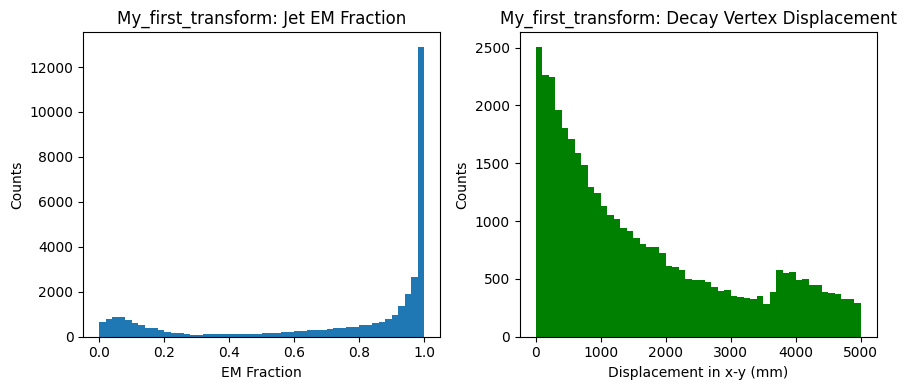

In [12]:
analyse(transformed_results, "My_first_transform")

#### Fast results from remote files

This is a standard demonstration of how a physicist can include `servicex` in frequent workflows.


From this notebook we managed to get histograms with releavant physics features extremely fast. All it took was to import 4 libraries and run 8 short cells. Plus this can be ran from everywhere on a laptop. 
<br>
To recap, obtaining such a result with standard tools would require: login to `lxplus` (or other), setupATLAS tools, validate Grid credentials, use `rucio` to download the DS, run your root macro or python script to get the histograms. 

<break>

If you consider another transformation (that ServiceX can do), and that would normaly require `Athena`/`AnalysisBase`, and the submission of Grid jobs, the difference would be even more blatant

## 4 – Other Transformer Types for root files

We will implement the same transformation but using other query types. ServiceX offers queries with declarative syntax to further simplify the user input. For these queries, the backend codegen will significantly expand the writen query to a standard C++ or Python code.  

### 4.1- UprootRaw 
This backend essentially executes a python script with uproot and awkward but uses functional programing. 

For a standard skimming, you must provide:
- `treename`: the TTree name you want to open 
- `filter_bame`: a list of branches to load from that Tree
- `cut`: The selection that you want to apply. It is done by using awkward methods such as:  `num, count, count_nonzero, any, all, sum, prod, min, max, argmin, argmax, mean, var, std`


In [13]:
#Build the same selection as above
uproot_raw_query=query.UprootRaw([{
    'treename':'reco',
    'filter_name':
      [ "truth_alp_decayVtxX",
        "truth_alp_decayVtxY",
        "truth_alp_pt",
        "truth_alp_eta",
        "jet_EMFrac_NOSYS", 
        "jet_pt_NOSYS" ],
    'cut':
        '(num(jet_pt_NOSYS)<2) & any((truth_alp_pt>20) & (abs(truth_alp_eta)<0.8))'}])
        

In [14]:
# Build the trasnform specification
spec_upraw = {
    'Sample': [{
        'Name': 'UprootRawExample',
        'Dataset': request_DS,
        'Query': uproot_raw_query
    }]
}

In [15]:
results_uproot_raw=deliver(spec_upraw)

Output()

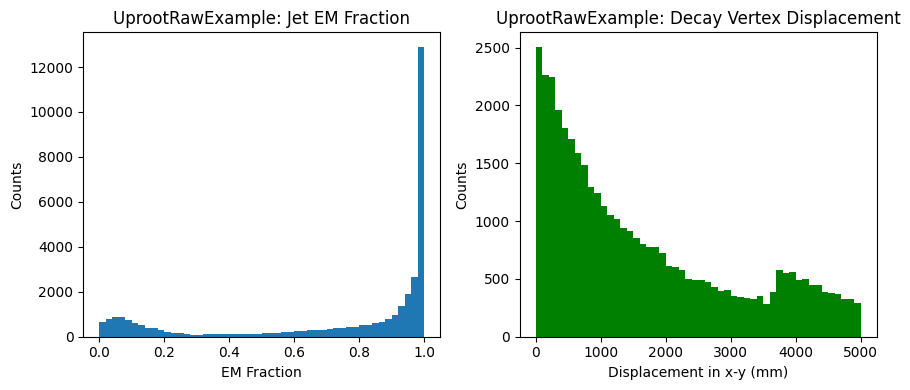

In [16]:
analyse(results_uproot_raw, "UprootRawExample")

**We obtain the exact same result, in a much shorter query definition!** <br>
However, not being able to explicitly chose what gets saved, all loaded branches are sent to the result file. 

### 4.2- Func ADL 
Functional Analysis Description Language, based on LINQ, is an SQL-like language used to construct hierarchical data queries for servicex. 
Func_adl it-self contains multiple backend options. It is written to work with different transformer types that use different environment builds. <br>

From the servicex client package one can directly build func_adl queries for different software types.<br>
Native `funcADL` backends in servicex:

In [17]:
list(query.plugins)[0:-2]

[EntryPoint(name='FuncADL_ATLASr21', value='servicex.func_adl.func_adl_dataset:FuncADLQuery_ATLASr21', group='servicex.query'),
 EntryPoint(name='FuncADL_ATLASr22', value='servicex.func_adl.func_adl_dataset:FuncADLQuery_ATLASr22', group='servicex.query'),
 EntryPoint(name='FuncADL_ATLASxAOD', value='servicex.func_adl.func_adl_dataset:FuncADLQuery_ATLASxAOD', group='servicex.query'),
 EntryPoint(name='FuncADL_CMS', value='servicex.func_adl.func_adl_dataset:FuncADLQuery_CMS', group='servicex.query'),
 EntryPoint(name='FuncADL_Uproot', value='servicex.func_adl.func_adl_dataset:FuncADLQuery_Uproot', group='servicex.query')]

#### Building blocks
FuncADL analysis language is made by multiple building block that can be combined in different ways to write a transformation. 
<br> The two main blocks are: 
- *Select* to select an object from the DS onto which further manipulations can be done, or to dump an object to the saved file with custom branch names. <br> Generally, it is analogous to opening a loop or writing out objects.
-  *Where* to apply the cuts, written as functions returning booleans (can be lambda functions) <br> It is analogous to an if statement within a loop. 

A list of all available building blocks can be found in [LINQ's Wikipedia](https://en.wikipedia.org/wiki/Language_Integrated_Query)<br>

Wrapping all these methods, with different nesting levels, enables a high modularity in the way you can express a transformation. 
This also allows you to build complex transformations on different separate objects with explicit "loop levels" and functions for event selection or variable building.

**Example with the FuncADL UpRoot backend**

In [18]:
#The selection functions must return a boolean
def jet_cut(evt) -> bool:
    return evt["jet_pt_NOSYS"].Count() < 2

def alp_pt_cut(evt) -> bool:
    # at least one ALP with pT > 20 GeV
    return evt["truth_alp_pt"].Where(lambda pt: pt > 20).Count() > 0

def alp_eta_cut(evt) -> bool:
    # at least one ALP with |η| < 0.8
    return evt["truth_alp_eta"].Where(lambda eta: abs(eta) < 0.8).Count() > 0

simple_query = query.FuncADL_Uproot() \
    .FromTree("reco") \
    .Where(jet_cut) \
    .Where(alp_pt_cut) \
    .Where(alp_eta_cut) \
    .Select(lambda e: {
        "jet_EMFrac_NOSYS":  e["jet_EMFrac_NOSYS"],
        "truth_alp_decayVtxX":  e["truth_alp_decayVtxX"],
        "truth_alp_decayVtxY": e["truth_alp_decayVtxY"],
    })


In [19]:
spec_funcadl = {
    'Sample': [{
        'Name': 'FuncADLExample',
        'Dataset': request_DS,
        'Query': simple_query
    }]
}

In [20]:
result_funcadl=deliver(spec_funcadl)

Output()

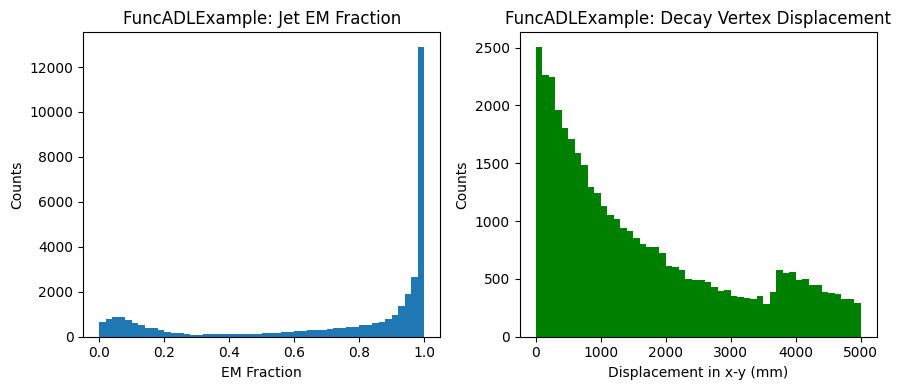

In [21]:
analyse(result_funcadl, "FuncADLExample")

We managed to obtain the same results using this servicex functional programming query type. The syntax is slightly more complex than the `UprootRaw` queries. However, its modularity allows for much better structuration of complex transformations into a single query. 


## 5 - ServiceX and ATLAS software for xAOD

The FuncADL query syntax becomes a great tool when one considers the ATLAS software backend. For such transformations, the `Select` and `Where` methods grant access to xAOD objects, their decorators, links, methods, CP tools... 
<br>

This notebook section showcases how to manipulate xAOD objects, like `TruthParticle` containers, as you would in `Athena` or `AnalysisBase` directly reading them from `DAOD` files. Further documentation and examples can be found in the [IRIS-HEP](https://iris-hep.org/xaod_usage/intro.html) webpage
<break>

In [22]:
#LLP1 DAOD
#Similar signal to what was in the Ntuple
DAOD="mc23_13p6TeV:mc23_13p6TeV.601806.PhPy8EG_AZNLO_ggH125_mA0p4_medium.deriv.DAOD_LLP1.e8526_e8528_s4111_s4114_r14622_r14663_p6368"
request_daod=dataset.Rucio(DAOD)

In [23]:
query_adl = query.FuncADL_ATLASr22()
#Building the TruthParticle_V1 xAOD object and filling it with the ALPs
truth_alp = query_adl.Select(
    lambda e: e
        .TruthParticles("TruthBSMWithDecayParticles")
        .Where(lambda p: p.absPdgId() == 35)
)

# Compute and write out the displacement by accessing TruthParticle decorators
truth_info = truth_alp.Select(
    lambda ts: {
        "LLP_Lxy": ts.Select(lambda p: (p.decayVtx().x()**2 + p.decayVtx().y()**2)**0.5),
    }
)

In [24]:
#Write the request specification
xAOD_spec = {
    "Sample": [
        {
            "Name": "func_adl_xAOD_simple",
            "Dataset": request_daod,
            "Query": truth_info,
            "NFiles": 1,
        }
    ]
}
xAOD_results = deliver(xAOD_spec)

Output()

Now that we downloaded the result, lets check some features of the displacement distribution for this signal. 

In [25]:
#Get the result and compute the percentage of in-tracker decays 
Lxy=to_awk(xAOD_results)["func_adl_xAOD_simple"]["LLP_Lxy"]
print(
    f"The BSM particle has a truth displacement mean of {ak.mean(Lxy): .2f} mm \
    \nApproximately {ak.count_nonzero(Lxy<1000)/len(Lxy)*100 :.1f} % of events have secondary vertices in ATLAS's tracker area"
)

The BSM particle has a truth displacement mean of  1812.80 mm     
Approximately 47.4 % of events have secondary vertices in ATLAS's tracker area


**Reminder:**

The standard workflow to reach this result with a DAOD would involve: setting up and writing an AnalysisBase or Athena package in C++, building the `initialize()`, `execute()` and `finalize()` functions, access the objects with specific handles, do the computation on the xAOD methods, compile everything in the correct release, write down a python config file with all the flags you need and the input file paths.     

Additionally, for larger operations one might have to configure ATLAS `panda` to distribute the job on the GRID.


With FuncADL, ServiceX offers an alternative to the standard usage of ATLAS software. Physicists can now do this type of R&D study much quickly and from their laptops. Thanks to the modular aspect of the syntax, more complex transforms can also be written. 
<br> 

Here is an [example of a large transformation](https://github.com/gordonwatts/sx_training_fetch/blob/main/calratio_training_data/training_query.py) that takes advantage of the xAOD backend to build ML training datasets directly from a derivation file.


## 6 - Some usefull functionalities 
In this section we will quickly showcase other utilities that can improve your `ServiceX` based workflow.
### 6.1 Sending transformation requests
- Request specifications: 
    - `General` block
        - `OutputFormat` for root-file, root-rntuple or parquet
        - `Delivery` to download files to LocalCache or get SignedURLs to the S3 store
        - Multiple `Sample` sub-blocks can be added. This allows different transforms per deliver call.<br>

    - `Sample` sub-block
        - `NFiles` to choose the number of files to transform for each dataset
        - `Dataset` there are other types of support DS types
        
    - `UprootRaw` queries
        - `copy_histogram` This transformer type can directly copy Root histograms from the original file
      

 
<break>
        
- `deliver` function

  
    - `backend`: the end-point server can be manually selected
    - `config_path`: the path to your servicex.yaml token
    - `spec_file`: Can be used to import the transform specification from a .yaml file
    -  Command line version for sending ServiceX trasnfoms from the shell

#### Command line example below:

In [26]:
#Executing from the terminal shell with spec file
!servicex deliver spec_file_example.yaml

Delivering spec_file_example.yaml to ServiceX cache
5l
{
    'CLI-Testing': 
['/private/var/folders/rl/c_v3j6t97j51xfs8rjlh0sfx2djbcf/T/servicex_acordeir/df7
48960-e2a5-4a2b-8f72-80a0d8d5b84e/root___c112.af.uchicago.edu_1094__root___dcgft
p.usatlas.bnl.gov_1094__pnfs_usatlas.bnl.gov_LOCALGROUPDISK_rucio_user_mtost_00_
05_user.mtost.43325207._000108.all_with_sys.root']
}


In [27]:
#See how the transform is written
#muon selection with jet tagging cuts
!cat spec_file_example.yaml

Sample:
  - Name: CLI-Testing
    Dataset: !Rucio user.mtost:user.mtost.all.Mar11
    NFiles: 1
    Query: !UprootRaw |
      [{"treename": "reco",
        "cut": "any(log(jet_GN2v01_pc / ((jet_GN2v01_pb * 0.3) + (jet_GN2v01_pu * (1 - 0.3)))) > 0.828, axis=1)", 
        "filter_name": ["mu_phi", "mu_eta", "mu_charge", "mu_e*", "mu_pt*"]
        },
        {"copy_histograms": ["CutBookkeeper*", "cflow*", "metadata", "listOfSystematics"]}
        ]
      


### 6.2 ServiceX errors and logs 
As the transformations run in the backend, the user does not have live access to the transformer logs. 
However, when a transformation fails, ServiceX will send the log body to a Kibana instance that can be accessed in a Browser. 

In [28]:
#Example of error in transformer execution

def run_query(input_filenames):
    return non_defined_variable

error_query=query.PythonFunction().with_uproot_function(run_query)

spec = {
    "Sample": [
        {
            "Name": "error_example",
            "Dataset": request_DS,
            "Query": error_query,
            "NFiles": 1,
        }
    ]
}
result_bug=deliver(spec)

Output()

[07/23/25 18:50:32] ERROR    A list of failed files is at ]8;id=138096;https://servicex.af.uchicago.edu//transformation-request//4c6c9e06-69ca-4998-9b98-43a54591134f/results?status=failure\this link]8;;\                               ]8;id=520029;file:///Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py\query_core.py]8;;\:]8;id=726953;file:///Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py#234\234]8;;\

                    ERROR    Transform Request id: 4c6c9e06-69ca-4998-9b98-43a54591134f           ]8;id=614863;file:///Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py\query_core.py]8;;\:]8;id=440024;file:///Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py#235\235]8;;\

                    ERROR    More information of 'error_example' ]8;id=251166;https://atlas-kibana.mwt2.org:5601/s/servicex/app/dashboards?auth_provider_hint=anonymous1#/view/6d069520-f34e-11ed-a6d8-9f6a16cd6d78?embed=true&_g=(time:(from:now-30d%2Fd,to:now))&_a=(filters:!((query:(match_phrase:(requestId:'4c6c9e06-69ca-4998-9b98-43a54591134f'))),(query:(match_phrase:(level:'error')))))&show-time-filter=true\HERE]8;;\                             ]8;id=835231;file:///Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py\query_core.py]8;;\:]8;id=68620;file:///Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py#245\245]8;;\

Exception in callback Query.submit_and_download.<locals>.transform_complete(<Task finishe...> result=None>) at 
/Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py:194
handle: <Handle Query.submit_and_download.<locals>.transform_complete(<Task finishe...> result=None>) at 
/Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py:194>
Traceback (most recent call last):
  File "/Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/acordeir/miniconda3/envs/servicex_analysis_env/lib/python3.9/site-packages/servicex/query_core.py", 
line 249, in transform_complete
    raise ServiceXException(errorstr)
servicex.query_core.ServiceXException: Transform "error_example" completed with failures: 1/1 files failed. Will 
not cache.

#### Finding the logs
After clicking the link printed by the deliver function you are directed to the kibana log errors for your request ID. A summary message is written but you can expand the error tab to find the `log_body` key. This is where the transformer logs can be found. 


 <h1 style="text-align: center;"><img src="images/error-log-hints.png" alt="error" width="800" height="80"></h1>


### 6.3 Remote file introspection with ServiceX

The `servicex_analysis_utils` package offers a function (`get_structure()`) that generates and sends a request to retrieve the metadata and file structure of a Rucio dataset. This tool, which can also be used on your terminal, becomes very useful whenever you need to know what is on a specific dataset. 
- For building ServiceX queries you need to know you dataset structure.
    -  TTrees/branch names
    -  available xAOD containers and decorations 
    -  Level of array nesting

In [29]:
from servicex_analysis_utils import get_structure

structure_string=get_structure(my_DS, filter_branch="jet")
print(structure_string)

Output()


File structure of all samples with branch filter 'jet':

---------------------------
📁 Sample: user.acordeir:michigan-tutorial.displaced-signal.root
---------------------------

🌳 Tree: EventLoop_FileExecuted
   ├── Branches:

🌳 Tree: EventLoop_JobStats
   ├── Branches:

🌳 Tree: reco
   ├── Branches:
   │   ├── jet_eta ; dtype: AsJagged(AsDtype('>f4'), header_bytes=10)
   │   ├── jet_phi ; dtype: AsJagged(AsDtype('>f4'), header_bytes=10)
   │   ├── num_truth_bjets_nocuts ; dtype: AsDtype('>i4')
   │   ├── num_truth_cjets_nocuts ; dtype: AsDtype('>i4')
   │   ├── jet_DRMinNoCuts_NOSYS ; dtype: AsJagged(AsDtype('>f4'), header_bytes=10)
   │   ├── jet_DRmin_NOSYS ; dtype: AsJagged(AsDtype('>f4'), header_bytes=10)
   │   ├── jet_EMFrac_NOSYS ; dtype: AsJagged(AsDtype('>f4'), header_bytes=10)
   │   ├── jet_Jvt_NOSYS ; dtype: AsJagged(AsDtype('>f4'), header_bytes=10)
   │   ├── jet_MatchType_NOSYS ; dtype: AsObjects(AsVector(True, AsString(False)))
   │   ├── jet_TagGNN_NOSYS ; dtype: AsJa

You get the full Tree structure of your dataset in a few seconds. Including the name of TTrees, TBranches, base types, and levels of nesting (Jaggness). 

It also allows you to check what are the available xAOD containers on AOD and DAOD files with branch name filtering. 



## 7 – Free hands-on  

In this section you are encouraged to try ServiceX for any transformation you have in mind.

- You can use either of the datasets `request_DS` or `request_daod`, or one that you might be familiar with.
- Try to use different transformer types `PythonFunction`, `UprootRaw`, `Fund_ADL_Uproot`, `Func_ADL_xAOD`.
- Remeber to use `get_structure` function to see what is available in the datasets.
- Try to make the best use of declarative syntax with the functional language queries.
- Some datasets have many files, you can set `NFiles` to 1 to quick test.

Here you have exercise suggestions for the datasets used in this notebook.

 #### Exercise suggestion 1:
 - Compute the invariant mass of the 2-lepton system
 - Select events with exactly 2 opposite-charge electrons or muons


Formula reminder for 2 reco objects:

 $\quad\quad$  $M^2 = 2 p_{T1} p_{T2} \left( \cosh(\eta_1 - \eta_2) - \cos(\phi_1 - \phi_2) \right)$

 #### Exercise suggestion 2:
  - Compute the invariant mass of the lepton-lepton-jet (leading) system on the LLP datasets
  - Implement a 40 GeV pt cut on the truth BSM particle (ALP)
  - Select events with exactly 2 opposite-charge leptons
  - Use Lorentz vectors
